In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Generate data set
The newly generated tampered images and xml files are placed in the `final submit/data/gene_2007_trainval/VOC2007` folder.

In [2]:
import os
from random import randint
from PIL import Image
import numpy as np
from lib.datasets.factory import get_imdb
from lib.datasets.xml_parse import *
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ElementTree, Element
from shutil import copyfile

DATASET_SIZE = 497

# Downloaded voc2017 data set path
dataset_dir_path = os.sep.join(['data', 'VOCdevkit2007', 'VOC2007'])
images_path = os.sep.join([dataset_dir_path, 'JPEGImages'])
image_annotation_path = os.sep.join([dataset_dir_path, 'Annotations'])

# Generated splicing data set path
gene_dir_path = os.sep.join(['data', 'gene_2007_trainval', 'VOC2007'])
gene_image_path = os.sep.join([gene_dir_path, 'JPEGImages'])
gene_annotation_path = os.sep.join([gene_dir_path, 'Annotations'])

imdb = get_imdb("voc_2007_trainval") # pascal_voc('trainval','2007')
roidb = imdb.roidb

image_index = imdb._load_image_set_index()
seg_index = imdb._load_seg_set_index()

# map: seg_index-->image_index
map = {i:image_index.index(seg_index[i]) for i in range(len(seg_index))}
print('map:', map)

def random_seg_idx():
    return randint(0, len(seg_index)-1)


def random_obj_idx(s):
    return randint(1, len(s)-2) #Remove 0, 255


def random_obj_loc(img_h, img_w, obj_h, obj_w):
    return randint(0, img_h - obj_h), randint(0, img_w - obj_w)


def find_obj_vertex(mask):
    hor = np.where(np.sum(mask, axis=0) > 0)
    ver = np.where(np.sum(mask, axis=1) > 0)
    return hor[0][0], hor[0][-1], ver[0][0], ver[0][-1]


def modify_xml(filename, savefile, xmin, ymin, xmax, ymax):
    def create_node(tag, property_map, content):
        element = Element(tag, property_map)
        element.text = content
        return element
    copyfile(filename, savefile)
    tree = ET.parse(savefile)
    root = tree.getroot()
    for obj in root.findall('object'):
        root.remove(obj)
    new_obj = Element('object', {})
    new_obj.append(create_node('name', {}, 'tampered'))
    bndbox = Element('bndbox', {})
    bndbox.append(create_node('xmin', {}, str(xmin)))
    bndbox.append(create_node('ymin', {}, str(ymin)))
    bndbox.append(create_node('xmax', {}, str(xmax)))
    bndbox.append(create_node('ymax', {}, str(ymax)))
    new_obj.append(bndbox)
    root.append(new_obj)
    tree.write(savefile)


if __name__ == '__main__':
    for count in range(DATASET_SIZE):
        if count % 100 == 0:
            print('>>> %d / %d' % (count, DATASET_SIZE))
        img_idx = count % len(image_index)# Prevent index access out of bounds
        img = Image.open(imdb.image_path_at(img_idx))   # Original image that needs to be modified
        
        loop_counter = 0
        while(loop_counter < 1000):

            loop_counter += 1
            seg_idx = random_seg_idx()# Randomly select seg_index
            seg = Image.open(imdb.seg_path_at(seg_idx)).convert('P')    # Segmentation ground truth to be cut out, mode "P" is 8-bit color image
            seg_img = Image.open(imdb.image_path_at(map[seg_idx]))  # To be cut out
            seg_np = np.asarray(seg)
            obj_idx = random_obj_idx(set(seg_np.flatten()))  # Randomly choose to tamper with obj, one color in the segmentation ground truth corresponds to one object, and set to remove duplicate elements
            mask2 = (seg_np == obj_idx) # Find out the area covered by tampering with obj
            min_x, max_x, min_y, max_y = find_obj_vertex(mask2) # Minimum circumscribed rectangle of coverage area
            
            # Find the right obj to jump out of the loop
            if((max_x - min_x) * (max_y - min_y) >= img.size[0] * img.size[1] * 0.01 and \
                (max_x - min_x) * (max_y - min_y) <= img.size[0] * img.size[1] * 0.3 and \
                max_x - min_x < img.size[0] and max_y - min_y < img.size[1]):
                break;

        print(imdb._image_index[map[seg_idx]],' added to ', imdb._image_index[img_idx])
        # Did not get a suitable size obj
        if loop_counter >= 1000:
            continue;
        
        #Use the tampered object to cover the corresponding part of the modified image, and only modify some pixels in the circumscribed rectangular area
        mask2 = mask2[min_y:max_y, min_x:max_x]
        mask = np.stack((mask2, mask2, mask2), axis=2)
        seg_img_np = np.asarray(seg_img).copy()[min_y:max_y, min_x:max_x, :]
        img_np = np.asarray(img).copy()
        # The relative position of the tampering object can be moved
        dx = max_x - min_x
        dy = max_y - min_y
        loc_y, loc_x = random_obj_loc(img.size[1], img.size[0], dy, dx)
        # The rectangular area of ​​the tampered image* (1-mask) + the rectangular area of ​​the tampered object*mask
        img_np[loc_y:loc_y + dy, loc_x:loc_x + dx, :] = img_np[loc_y:loc_y + dy, loc_x:loc_x + dx, :] * (1-mask) + seg_img_np * mask

        new_img = Image.fromarray(img_np, mode='RGB')

        new_img.save(os.sep.join([gene_image_path, image_index[img_idx] + '.jpg']))  # save
        modify_xml(os.sep.join([image_annotation_path, image_index[img_idx] + '.xml']),
                   os.sep.join([gene_annotation_path, image_index[img_idx] + '.xml']),
                   loc_x + 1, loc_y + 1, loc_x + dx, loc_y + dy)


ModuleNotFoundError: No module named 'lib.utils.cython_bbox'

## Training section

In [1]:
import time

import numpy as np
import tensorflow as tf
from tensorflow.python import pywrap_tensorflow

import lib.config.config as cfg
from lib.datasets import roidb as rdl_roidb
from lib.datasets.factory import get_imdb
from lib.datasets.imdb import imdb as imdb2
from lib.layer_utils.roi_data_layer import RoIDataLayer
from lib.nets.vgg16 import vgg16

from lib.utils.timer import Timer


try:
    import cPickle as pickle
except ImportError:
    import pickle
import os


In [ ]:

tf.reset_default_graph()

class Train:
    def __init__(self):

        # Create network
        if cfg.temps['net'] == 'vgg_16':
            self.net = vgg16(batch_size=cfg.temps['ims_per_batch'])
        else:
            raise NotImplementedError

        self.imdb = get_imdb("gene_2007_trainval")
        self.roidb = rdl_roidb.get_roidb(self.imdb)

        self.data_layer = RoIDataLayer(self.roidb, self.imdb.num_classes)
        self.output_dir = cfg.get_output_dir(self.imdb, 'default') # Output folder path

    def train(self):

        # Create session
        tfconfig = tf.ConfigProto(allow_soft_placement=True)  # Automatically allocate GPU or CPU according to device conditions
        tfconfig.gpu_options.allow_growth = True #Tensorflow runs automatically and slowly reaches the maximum GPU memory
        # tfconfig.gpu_options.per_process_gpu_memory_fraction = 0.90#When using GPU, set the maximum ratio of GPU memory usage
        sess = tf.Session(config=tfconfig)

        with sess.graph.as_default():

            tf.set_random_seed(cfg.temps['rng_seed']) # Set the seed parameter of the random function, the corresponding variable can generate the same random number across sessions
            layers = self.net.create_architecture(sess, "TRAIN", self.imdb.num_classes, tag='default')
            loss = layers['total_loss']
            lr = tf.Variable(cfg.temps['learning_rate'], trainable=False)
            momentum = cfg.temps['momentum']
            optimizer = tf.train.MomentumOptimizer(lr, momentum)

            gvs = optimizer.compute_gradients(loss)

            # Double bias
            # Double the gradient of the bias if set
            if cfg.temps['double_bias']:
                final_gvs = []
                with tf.variable_scope('Gradient_Mult'):
                    for grad, var in gvs:
                        scale = 1.
                        if cfg.temps['double_bias'] and '/biases:' in var.name:
                            scale *= 2.
                        if not np.allclose(scale, 1.0):
                            grad = tf.multiply(grad, scale)
                        final_gvs.append((grad, var))
                train_op = optimizer.apply_gradients(final_gvs)
            else:
                train_op = optimizer.apply_gradients(gvs)

            # We will handle the snapshots ourselves
            self.saver = tf.train.Saver(max_to_keep=100000)
            # Write the train and validation information to tensorboard
            writer = tf.summary.FileWriter('default/', sess.graph)
            # valwriter = tf.summary.FileWriter(self.tbvaldir)

        # Load weights
        # Fresh train directly from ImageNet weights
        print('Loading initial model weights from {:s}'.format(cfg.temps['pretrained_model']))
        variables = tf.global_variables()
        # Initialize all variables first
        sess.run(tf.variables_initializer(variables, name='init'))
        var_keep_dic = self.get_variables_in_checkpoint_file(cfg.temps['pretrained_model'])
        # Get the variables to restore, ignorizing the variables to fix
        variables_to_restore = self.net.get_variables_to_restore(variables, var_keep_dic, sess,
                                                                 cfg.temps['pretrained_model'])

        restorer = tf.train.Saver(variables_to_restore)
        restorer.restore(sess, cfg.temps['pretrained_model'])
        print('Loaded.')
        # Need to fix the variables before loading, so that the RGB weights are changed to BGR
        # For VGG16 it also changes the convolutional weights fc6 and fc7 to
        # fully connected weights
        self.net.fix_variables(sess, cfg.temps['pretrained_model'])
        print('Fixed.')
        sess.run(tf.assign(lr, cfg.temps['learning_rate']))
        last_snapshot_iter = 0

        timer = Timer()
        iter = last_snapshot_iter + 1
        last_summary_time = time.time()
        print('START TRAINING: ...')
        while iter < cfg.temps['max_iters'] + 1:
            # Learning rate
            if iter == cfg.temps['step_size'] + 1:
                # Add snapshot here before reducing the learning rate
                # self.snapshot(sess, iter)
                sess.run(tf.assign(lr, cfg.temps['learning_rate'] * cfg.temps['gamma']))
            
            timer.tic()
            # Get training data, one batch at a time
            blobs = self.data_layer.forward()
            iter += 1
            # Compute the graph without summary
            if iter % 100 == 0:
                rpn_loss_cls, rpn_loss_box, loss_cls, loss_box, total_loss, summary = self.net.train_step_with_summary(
                    sess, blobs, train_op)
                timer.toc()

                run_metadata = tf.RunMetadata()
                writer.add_run_metadata(run_metadata, 'step%03d' % iter)
                writer.add_summary(summary, iter)
            else:
                rpn_loss_cls, rpn_loss_box, loss_cls, loss_box, total_loss = self.net.train_step(
                    sess, blobs, train_op)
                timer.toc()

            # Display training information
            if iter % (cfg.temps['display']) == 0:
                print('iter: %d / %d, total loss: %.6f\n >>> rpn_loss_cls: %.6f\n '
                      '>>> rpn_loss_box: %.6f\n >>> loss_cls: %.6f\n >>> loss_box: %.6f\n ' % \
                      (iter, cfg.temps['max_iters'], total_loss, rpn_loss_cls, rpn_loss_box, loss_cls, loss_box))
                print('speed: {:.3f}s / iter'.format(timer.average_time))

            if iter % cfg.temps['snapshot_iterations'] == 0:
                self.snapshot(sess, iter)

    def get_variables_in_checkpoint_file(self, file_name):
        try:
            reader = pywrap_tensorflow.NewCheckpointReader(file_name)
            var_to_shape_map = reader.get_variable_to_shape_map()
            return var_to_shape_map
        except Exception as e:  # pylint: disable=broad-except
            print(str(e))
            if "corrupted compressed block contents" in str(e):
                print("It's likely that your checkpoint file has been compressed "
                      "with SNAPPY.")

    def snapshot(self, sess, iter):
        net = self.net

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        # Store the model snapshot
        filename = 'vgg16_faster_rcnn_iter_{:d}'.format(iter) + '.ckpt'
        filename = os.path.join(self.output_dir, filename)
        self.saver.save(sess, filename)
        print('Wrote snapshot to: {:s}'.format(filename))

        # Also store some meta information, random state, etc.
        nfilename = 'vgg16_faster_rcnn_iter_{:d}'.format(iter) + '.pkl'
        nfilename = os.path.join(self.output_dir, nfilename)
        # current state of numpy random
        st0 = np.random.get_state()
        # current position in the database
        cur = self.data_layer._cur
        # current shuffled indeces of the database
        perm = self.data_layer._perm

        # Dump the meta info
        with open(nfilename, 'wb') as fid:
            pickle.dump(st0, fid, pickle.HIGHEST_PROTOCOL)
            pickle.dump(cur, fid, pickle.HIGHEST_PROTOCOL)
            pickle.dump(perm, fid, pickle.HIGHEST_PROTOCOL)
            pickle.dump(iter, fid, pickle.HIGHEST_PROTOCOL)

        return filename, nfilename


if __name__ == '__main__':
    train = Train()
    train.train()


Loaded dataset `gene_2007_trainval` for training
Set proposal method: gt
Appending horizontally-flipped training examples...
cache_path:  /home/jovyan/personal_proj/new from lcal/test 101/final submit/data/cache
wrote gt roidb to /home/jovyan/personal_proj/new from lcal/test 101/final submit/data/cache/gene_2007_trainval_gt_roidb_loacl.pkl
done
Preparing training data...


W0702 16:07:15.265178 140499201681216 deprecation_wrapper.py:119] From /home/jovyan/personal_proj/new from lcal/test 101/final submit/lib/nets/network.py:258: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0702 16:07:15.271028 140499201681216 deprecation_wrapper.py:119] From /home/jovyan/personal_proj/new from lcal/test 101/final submit/lib/nets/network.py:284: The name tf.no_regularizer is deprecated. Please use tf.compat.v1.no_regularizer instead.

W0702 16:07:15.272032 140499201681216 deprecation_wrapper.py:119] From /home/jovyan/personal_proj/new from lcal/test 101/final submit/lib/nets/vgg16.py:15: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



done
{'rng_seed': 3, 'net': 'vgg_16', 'weight_decay': 0.0005, 'learning_rate': 0.001, 'momentum': 0.9, 'gamma': 0.1, 'batch_size': 256, 'max_iters': 3000, 'step_size': 30000, 'display': 50, 'initializer': 'truncated', 'pretrained_model': './data/imagenet_weights/vgg_16.ckpt', 'bias_decay': False, 'double_bias': True, 'use_all_gt': True, 'max_size': 1000, 'test_max_size': 1000, 'ims_per_batch': 1, 'snapshot_iterations': 2000, 'test_mode': 'top', 'rpn_negative_overlap': 0.3, 'rpn_positive_overlap': 0.7, 'rpn_fg_fraction': 0.5, 'rpn_train_nms_thresh': 0.7, 'rpn_test_nms_thresh': 0.7, 'rpn_train_pre_nms_top_n': 20000, 'rpn_train_post_nms_top_n': 8000, 'rpn_test_pre_nms_top_n': 8000, 'rpn_test_post_nms_top_n': 500, 'rpn_batchsize': 256, 'rpn_positive_weight': -1, 'rpn_top_n': 300, 'rpn_clobber_positives': False, 'proposal_fg_fraction': 0.25, 'proposal_use_gt': False, 'roi_fg_threshold': 0.5, 'roi_bg_threshold_high': 0.5, 'roi_bg_threshold_low': 0.1, 'bbox_normalize_targets_precomputed': Tru

W0702 16:07:16.062872 140499201681216 deprecation_wrapper.py:119] From /home/jovyan/personal_proj/new from lcal/test 101/final submit/lib/nets/network.py:181: The name tf.ceil is deprecated. Please use tf.math.ceil instead.

W0702 16:07:16.068030 140499201681216 deprecation.py:323] From /home/jovyan/personal_proj/new from lcal/test 101/final submit/lib/nets/network.py:181: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0702 16:07:16.073380 140499201681216 deprecation.py:323] From /home/jovyan/personal_proj/new from lcal/test 101/final submit/lib/nets/network.py:186: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arr

Loading initial model weights from ./data/imagenet_weights/vgg_16.ckpt


W0702 16:07:21.278874 140499201681216 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Variables restored: vgg_16/conv1/conv1_1/biases:0
Variables restored: vgg_16/conv1/conv1_2/weights:0
Variables restored: vgg_16/conv1/conv1_2/biases:0
Variables restored: vgg_16/conv2/conv2_1/weights:0
Variables restored: vgg_16/conv2/conv2_1/biases:0
Variables restored: vgg_16/conv2/conv2_2/weights:0
Variables restored: vgg_16/conv2/conv2_2/biases:0
Variables restored: vgg_16/conv3/conv3_1/weights:0
Variables restored: vgg_16/conv3/conv3_1/biases:0
Variables restored: vgg_16/conv3/conv3_2/weights:0
Variables restored: vgg_16/conv3/conv3_2/biases:0
Variables restored: vgg_16/conv3/conv3_3/weights:0
Variables restored: vgg_16/conv3/conv3_3/biases:0
Variables restored: vgg_16/conv4/conv4_1/weights:0
Variables restored: vgg_16/conv4/conv4_1/biases:0
Variables restored: vgg_16/conv4/conv4_2/weights:0
Variables restored: vgg_16/conv4/conv4_2/biases:0
Variables restored: vgg_16/conv4/conv4_3/weights:0
Variables restored: vgg_16/conv4/conv4_3/biases:0
Variables restored: vgg_16/conv5/conv5_1/

W0702 16:07:21.453464 140499201681216 deprecation.py:506] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0702 16:07:21.476590 140499201681216 deprecation_wrapper.py:119] From /home/jovyan/personal_proj/new from lcal/test 101/final submit/lib/nets/vgg16.py:107: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.



Loaded.
Fix VGG16 layers..
Fixed.
START TRAINING: ...
max_overlaps 3687
[0.12213293 0.         0.05682405 ... 0.05955505 0.         0.        ]
max_overlaps 4205
[0.09396629 0.16169516 0.         ... 0.07747601 0.         0.        ]
max_overlaps 4041
[0. 0. 0. ... 0. 0. 0.]
max_overlaps 3506
[0.16539295 0.14961931 0.         ... 0.17122427 0.         0.        ]
max_overlaps 3762
[0. 0. 0. ... 0. 0. 0.]
max_overlaps 3789
[0.37491346 0.33208651 0.03579483 ... 0.         0.         0.04823247]
max_overlaps 4283
[0.         0.         0.04752534 ... 0.         0.         0.        ]
max_overlaps 3810
[0. 0. 0. ... 0. 0. 0.]
max_overlaps 3769
[0. 0. 0. ... 0. 0. 0.]
max_overlaps 4368
[0.         0.         0.         ... 0.         0.06070523 0.03188165]
max_overlaps 3778
[0.16307558 0.11722729 0.         ... 0.0628455  0.         0.        ]
max_overlaps 4192
[0.15236292 0.38300631 0.         ... 0.38519336 0.00723946 0.        ]
max_overlaps 3782
[0.        0.        0.        ... 0.   

default/gene_2007_trainval/default/vgg16_faster_rcnn_iter_40000.ckpt
{'rng_seed': 3, 'net': 'vgg_16', 'weight_decay': 0.0005, 'learning_rate': 0.001, 'momentum': 0.9, 'gamma': 0.1, 'batch_size': 256, 'max_iters': 3000, 'step_size': 30000, 'display': 50, 'initializer': 'truncated', 'pretrained_model': './data/imagenet_weights/vgg_16.ckpt', 'bias_decay': False, 'double_bias': True, 'use_all_gt': True, 'max_size': 1000, 'test_max_size': 1000, 'ims_per_batch': 1, 'snapshot_iterations': 2000, 'test_mode': 'top', 'rpn_negative_overlap': 0.3, 'rpn_positive_overlap': 0.7, 'rpn_fg_fraction': 0.5, 'rpn_train_nms_thresh': 0.7, 'rpn_test_nms_thresh': 0.7, 'rpn_train_pre_nms_top_n': 20000, 'rpn_train_post_nms_top_n': 8000, 'rpn_test_pre_nms_top_n': 8000, 'rpn_test_post_nms_top_n': 500, 'rpn_batchsize': 256, 'rpn_positive_weight': -1, 'rpn_top_n': 300, 'rpn_clobber_positives': False, 'proposal_fg_fraction': 0.25, 'proposal_use_gt': False, 'roi_fg_threshold': 0.5, 'roi_bg_threshold_high': 0.5, 'roi_b

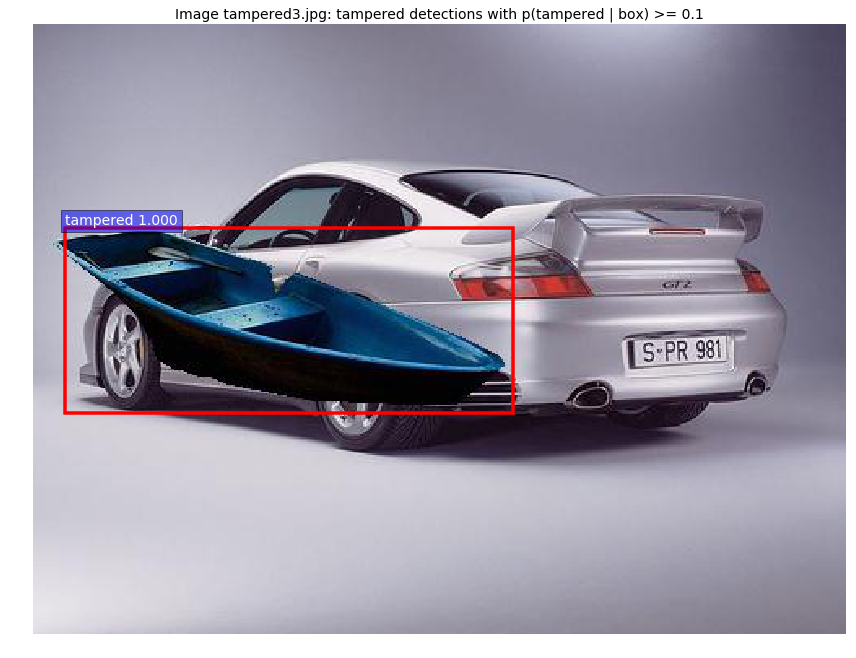

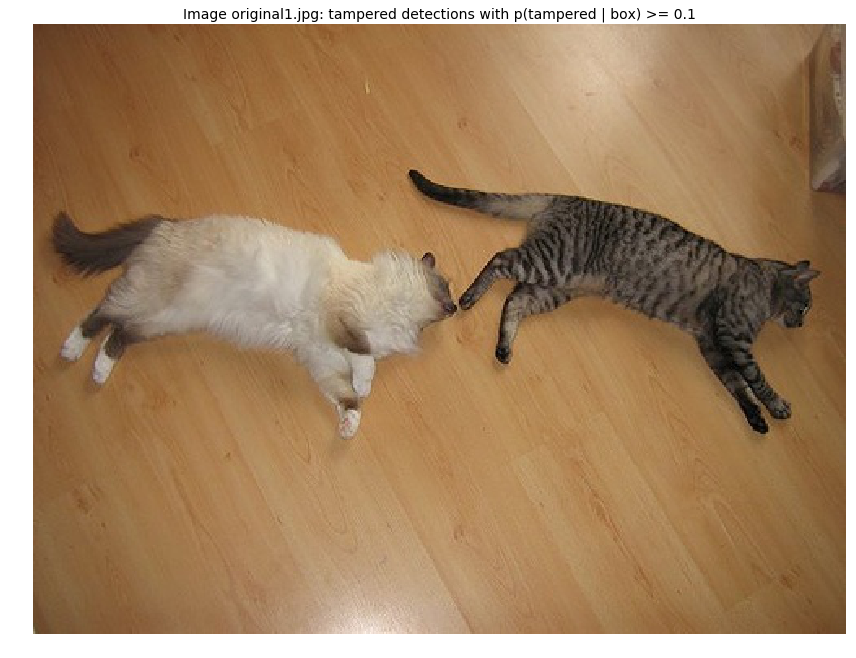

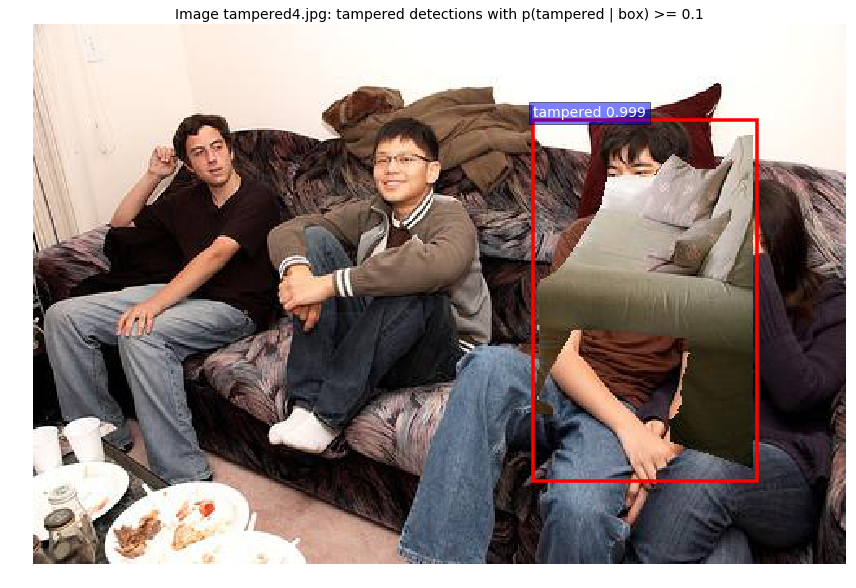

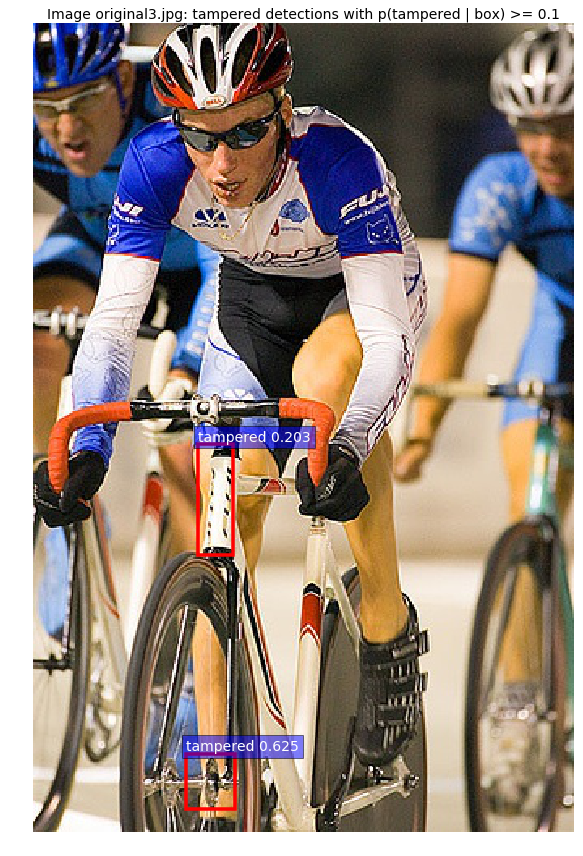

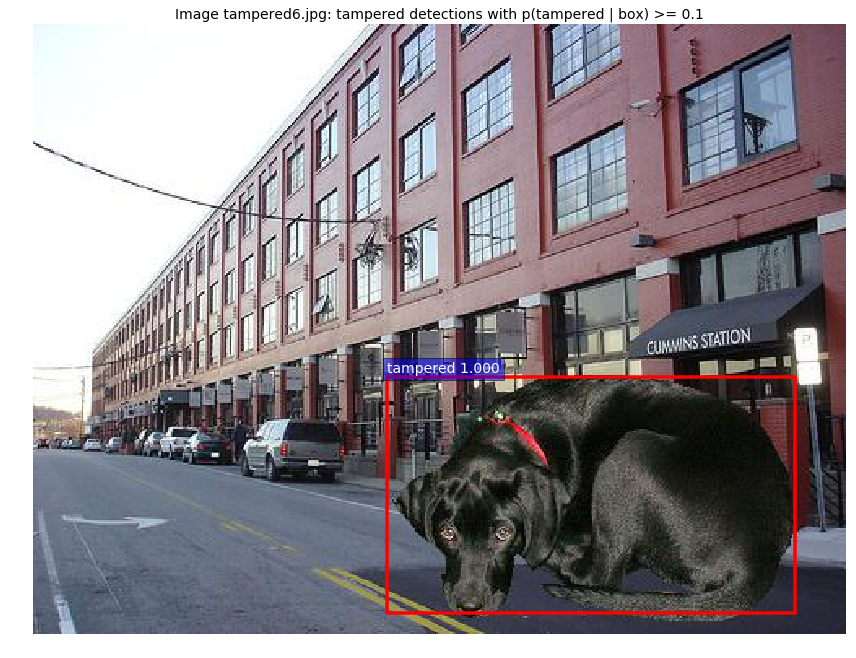

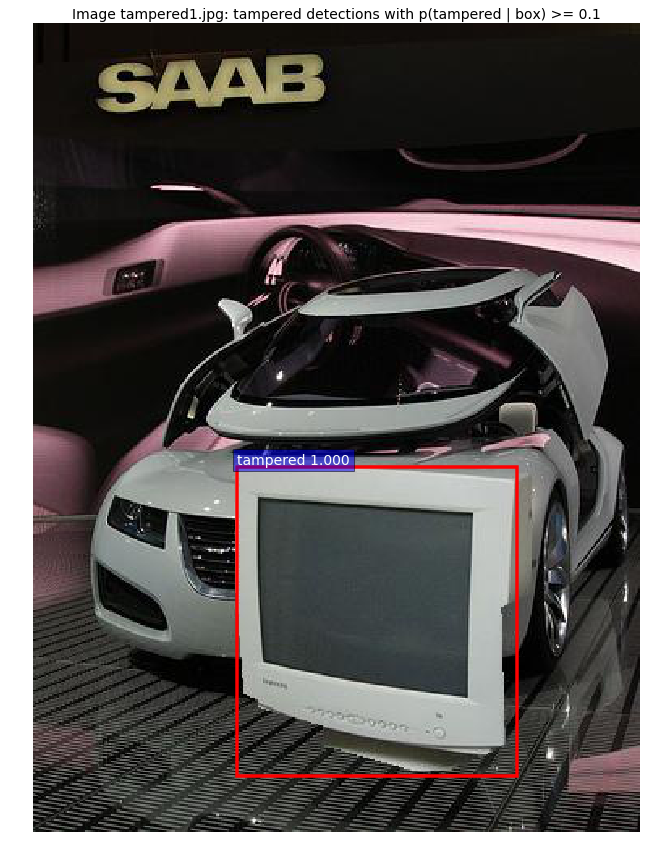

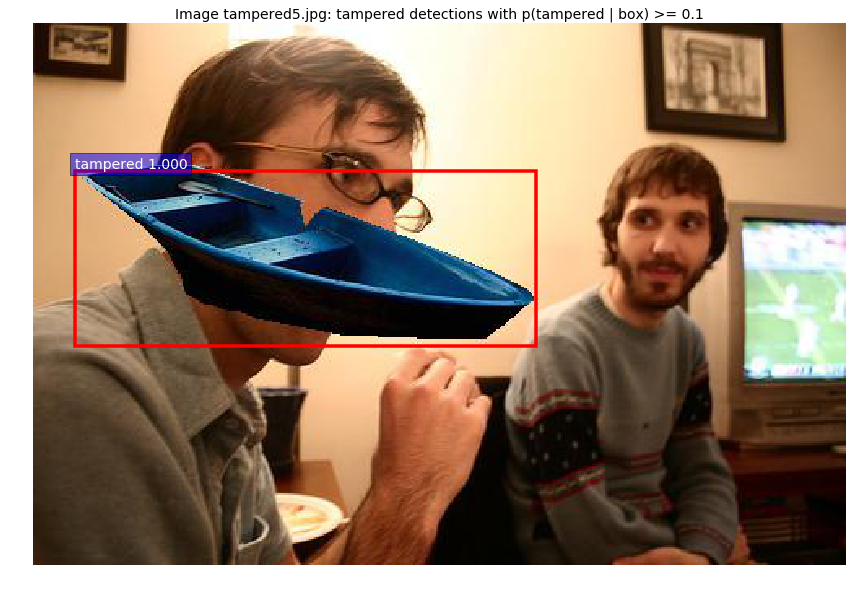

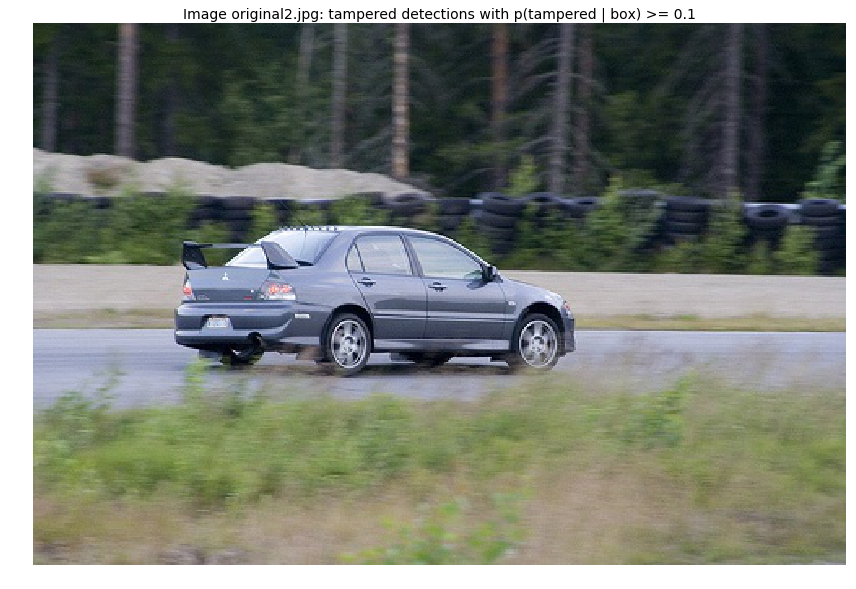

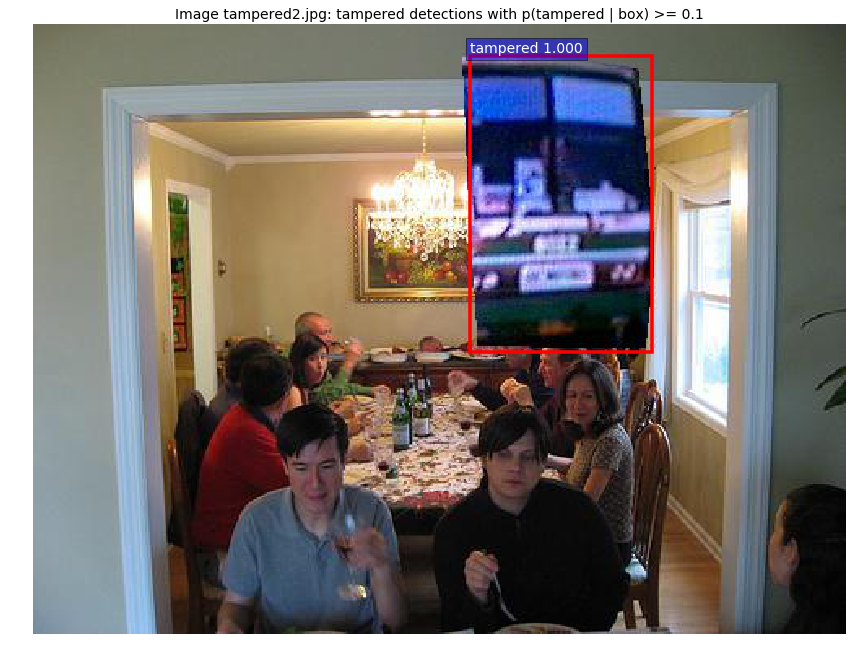

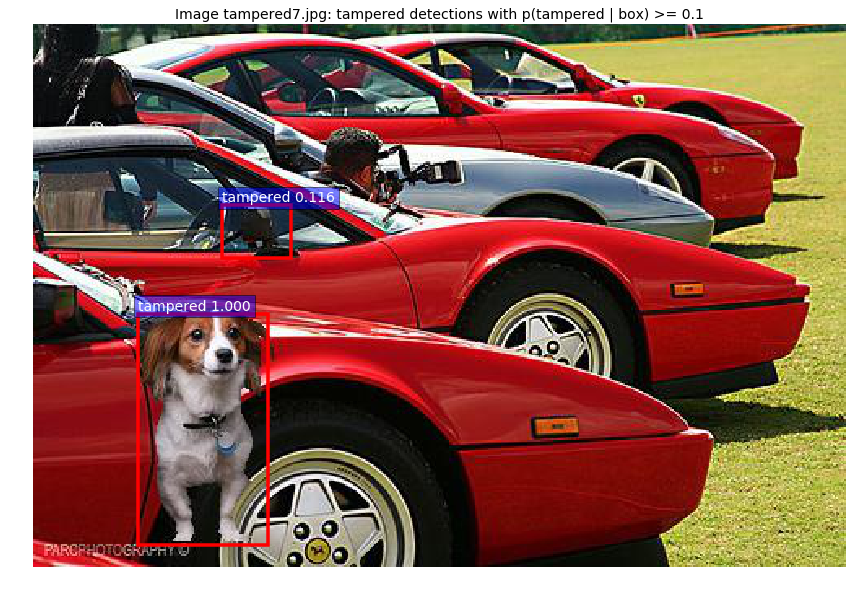

In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from lib.config import config as cfg
from lib.utils.nms_wrapper import nms
from lib.utils.test import im_detect
#from nets.resnet_v1 import resnetv1
from lib.nets.vgg16 import vgg16
from lib.utils.timer import Timer

tf.reset_default_graph()
%matplotlib inline

CLASSES = ('__background__',
           'tampered')

# PLEASE specify weight files dir for vgg16
NETS = {'vgg16': ('vgg16_faster_rcnn_iter_40000.ckpt',)}
DATASETS = {'pascal_voc': ('voc_2007_trainval',)}


def vis_detections(im, class_name, dets, image_name,thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
        )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('Image {}: {} detections with '
                  'p({} | box) >= {:.1f}').format(image_name,class_name, class_name,
                                                  thresh),
                 fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join('data/ImageForTest', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.1
    NMS_THRESH = 0.1

    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1  # because we skipped background
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets,image_name, thresh=CONF_THRESH)


def parse_args():
    """Parse input arguments."""
    
    parser = argparse.ArgumentParser(description='Tensorflow Faster R-CNN demo')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg_16 res101]',
                        choices=NETS.keys(), default='vgg16')
    parser.add_argument('--dataset', dest='dataset', help='Trained dataset [pascal_voc pascal_voc_0712]',
                        choices=DATASETS.keys(), default='pascal_voc_0712')
    args = parser.parse_args(args=[])
    return args


if __name__ == '__main__':

    args = parse_args()
    # model path
    demonet = args.demo_net
    dataset = args.dataset
    tfmodel = os.path.join('default', 'gene_2007_trainval', 'default', NETS[demonet][0])
    print(tfmodel)
    if not os.path.isfile(tfmodel + '.meta'):
        print(tfmodel)
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(tfmodel + '.meta'))
    
    # set config
    tfconfig = tf.ConfigProto(allow_soft_placement=True)
    tfconfig.gpu_options.allow_growth = True

    # init session
    sess = tf.Session(config=tfconfig)
    # load network
    if demonet == 'vgg16':
        net = vgg16(batch_size=1)
    # elif demonet == 'res101':
        # net = resnetv1(batch_size=1, num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(sess, "TEST", 2,
                            tag='default', anchor_scales=[8, 16, 32])
    saver = tf.train.Saver()
    saver.restore(sess, tfmodel)

    print('Loaded network {:s}'.format(tfmodel))

    for file in os.listdir("./data/ImageForTest"):
        if file.endswith(".jpg"):
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print('Demo for data/ImageForTest/{}'.format(file))
            demo(sess, net, file)

    plt.show()